# Library Import

In [81]:
# 한국어 텍스트 감정 분석을 위한 필수 라이브러리들
from collections import Counter  # 카운터 자료구조
import os  # 운영체제 인터페이스
import platform  # 플랫폼 정보
import re  # 정규 표현식
import sys  # 시스템 정보
import warnings  # 경고 메시지 제어
import math


import matplotlib.pyplot as plt  # 데이터 시각화
plt.rc("font", family="NanumBarunGothic")  # 한글 폰트 설정(없으면 설치 필요)

import numpy as np  # 수치 연산
import pandas as pd  # 데이터 처리 및 분석
import seaborn as sns  # 고급 시각화
import torch  # 딥러닝 프레임워크
import koreanize_matplotlib
import wandb
# 머신러닝 관련 라이브러리
from sklearn.metrics import accuracy_score, f1_score  # 평가 지표
from sklearn.model_selection import train_test_split, StratifiedKFold  # 데이터 분할

# 트랜스포머 및 BERT 관련 라이브러리
from transformers import (
    AutoModelForSequenceClassification,  # 시퀀스 분류 모델
    AutoTokenizer,  # 토크나이저
    DataCollatorWithPadding,  # 패딩 데이터 콜레이터
    set_seed,
    Trainer,  # 트레이너
    TrainingArguments,  # 훈련 설정
)

# PyTorch 데이터 처리
from torch.utils.data import Dataset  # 데이터셋 및 데이터로더

# 경고 메시지 필터링
warnings.filterwarnings("ignore")

# 라이브러리 버전 정보 출력 (재현성을 위함)
print("=== 라이브러리 버전 정보 ===")
print(f"Python: {sys.version}")
print(f"Platform: {platform.platform()}")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"torch: {torch.__version__}")
print(f"transformers: {__import__('transformers').__version__}")
print(f"sklearn: {__import__('sklearn').__version__}")
print(f"matplotlib: {__import__('matplotlib').__version__}")
print(f"seaborn: {sns.__version__}")

# GPU 사용 가능 여부 확인
print("\n=== PyTorch GPU 지원 정보 ===")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA 버전: {torch.version.cuda}")
    print(f"GPU 개수: {torch.cuda.device_count()}")
    print(f"현재 GPU: {torch.cuda.current_device()}")
    print(f"GPU 이름: {torch.cuda.get_device_name()}")
else:
    print("CPU에서 실행 중")

=== 라이브러리 버전 정보 ===
Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
Platform: Linux-5.4.0-99-generic-x86_64-with-glibc2.31
pandas: 2.2.3
numpy: 1.26.4
torch: 2.6.0+cu124
transformers: 4.55.0
sklearn: 1.6.1
matplotlib: 3.10.5
seaborn: 0.13.2

=== PyTorch GPU 지원 정보 ===
CUDA 사용 가능: True
CUDA 버전: 12.4
GPU 개수: 1
현재 GPU: 0
GPU 이름: Tesla V100-SXM2-32GB


In [82]:
from dotenv import load_dotenv
import os

# 이 함수가 .env 파일을 읽어서 환경 변수로 로드합니다.
load_dotenv()

True

## Random Seed Configuration

In [83]:
# 랜덤 시드 설정
RANDOM_STATE = 42


set_seed(RANDOM_STATE)

print(f"랜덤 시드 {RANDOM_STATE}로 설정 완료")

랜덤 시드 42로 설정 완료


# Data Load

In [84]:
# 데이터 로드
df = pd.read_csv("data/train.csv")

# 처음 몇 행 표시
print("\n처음 5행:")
df.head()


처음 5행:


,ID,review,label,type
0,0,이 영화는 정말 여성의 강인함과 힘을 제대로 보여주는 작품이었어요! 주인공이 자기 ...,2,augment
1,1,어느 부잣집 도련님의 철없는 행각,1,original
2,3,왜이렇게 재미가없냐 원도 별로였지만 원보다 더 재미없네,0,original
3,4,크리스마스 시즌엔 무조건 홈 알론이죠! 맥컬리 컬킨이 연기한 케빈의 재치있고 천방지...,2,augment
4,5,참나ㅋㅋ이게 무슨 드라마 최초 뮤지컬드라마야 이게무슨ㅋㅋ걍 다른 드라마랑 똑같구만 ...,0,original


# EDA (Explanatory Data Analysis)


## 데이터 개요 및 품질 검사

- 데이터셋 형태 및 기본 정보
- 결측값
- 중복값
- 데이터 타입 확인


In [ ]:
# 데이터셋 크기 및 기본 정보 확인
print(f"데이터셋 형태: {df.shape}")
print(f"행 수: {df.shape[0]}")
print(f"열 수: {df.shape[1]}")
print(f"열 이름: {list(df.columns)}")

# 타입별 데이터 분포 확인
print("\n타입별 데이터 분포:")
type_counts = df["type"].value_counts()
type_percentages = df["type"].value_counts(normalize=True) * 100
for type_name, count in type_counts.items():
    percentage = type_percentages[type_name]
    print(f"  {type_name}: {count:,}개 ({percentage:.1f}%)")

# 결측값 확인
print("\n결측값:")
print(df.isnull().sum())

# 중복값 확인
print(f"\n중복 리뷰: {df['review'].duplicated().sum()}")
print(f"중복 행: {df.duplicated().sum()}")

if df["review"].duplicated().sum() > 0:
    print("\n중복된 리뷰 예시:")
    duplicated_reviews = df[df["review"].duplicated(keep=False)].sort_values("review")
    print(duplicated_reviews[["review", "label", "type"]].head(10))

# 데이터 타입 확인
print("\n데이터 타입:")
print(df.dtypes)


데이터셋 형태: (279650, 4)
행 수: 279650
열 수: 4
열 이름: ['ID', 'review', 'label', 'type']

타입별 데이터 분포:
  augment: 139,825개 (50.0%)
  original: 139,825개 (50.0%)

결측값:
ID        0
review    6
label     0
type      0
dtype: int64

중복 리뷰: 3350
중복 행: 0

중복된 리뷰 예시:
       review  label      type
112658      !      2  original
197409      !      0  original
235169    -_-      0  original
85131     -_-      0  original
140661    -_-      0  original
35114       0      1  original
187569      0      1  original
159660     0점      0  original
217122     0점      0  original
209801     0점      0  original

데이터 타입:
ID         int64
review    object
label      int64
type      object
dtype: object


## 타입별 데이터 분석

- Original vs Augment 데이터 비교
- 타입별 클래스 분포
- 타입별 텍스트 특성 분석


In [ ]:
# 타입별 상세 분석
print("=" * 50)
print("타입별 데이터 분석")
print("=" * 50)

# 타입별 기본 통계
for data_type in df["type"].unique():
    type_data = df[df["type"] == data_type]
    print(f"\n[{data_type.upper()} 데이터]")
    print(f"  총 개수: {len(type_data):,}개")
    print(f"  비율: {len(type_data)/len(df)*100:.1f}%")
    
    # 타입별 클래스 분포
    print(f"  클래스 분포:")
    type_class_counts = type_data["label"].value_counts().sort_index()
    type_class_percentages = type_data["label"].value_counts(normalize=True).sort_index() * 100
    for label, count in type_class_counts.items():
        percentage = type_class_percentages[label]
        print(f"    클래스 {label} ({LABEL_MAPPING[label]}): {count:,}개 ({percentage:.1f}%)")
    
    # 타입별 텍스트 길이 통계
    type_data["text_length"] = type_data["review"].str.len()
    type_data["word_count"] = type_data["review"].str.split().str.len()
    
    print(f"  텍스트 길이 통계:")
    print(f"    평균 문자 수: {type_data['text_length'].mean():.1f}")
    print(f"    평균 단어 수: {type_data['word_count'].mean():.1f}")
    print(f"    최대 문자 수: {type_data['text_length'].max()}")
    print(f"    최소 문자 수: {type_data['text_length'].min()}")

print("\n✅ 타입별 분석 완료")


타입별 데이터 분석

[AUGMENT 데이터]
  총 개수: 139,825개
  비율: 50.0%
  클래스 분포:
    클래스 0 (강한 부정): 57,033개 (40.8%)
    클래스 1 (약한 부정): 13,608개 (9.7%)
    클래스 2 (약한 긍정): 49,708개 (35.6%)
    클래스 3 (강한 긍정): 19,476개 (13.9%)
  텍스트 길이 통계:
    평균 문자 수: 282.0
    평균 단어 수: 69.9
    최대 문자 수: 2035
    최소 문자 수: 44

[ORIGINAL 데이터]
  총 개수: 139,825개
  비율: 50.0%
  클래스 분포:
    클래스 0 (강한 부정): 57,033개 (40.8%)
    클래스 1 (약한 부정): 13,608개 (9.7%)
    클래스 2 (약한 긍정): 49,708개 (35.6%)
    클래스 3 (강한 긍정): 19,476개 (13.9%)
  텍스트 길이 통계:
    평균 문자 수: 35.3
    평균 단어 수: 7.6
    최대 문자 수: 142.0
    최소 문자 수: 1.0

✅ 타입별 분석 완료


텍스트 길이 및 단어 수 컬럼 생성 중...
✅ 텍스트 길이 및 단어 수 컬럼 생성 완료


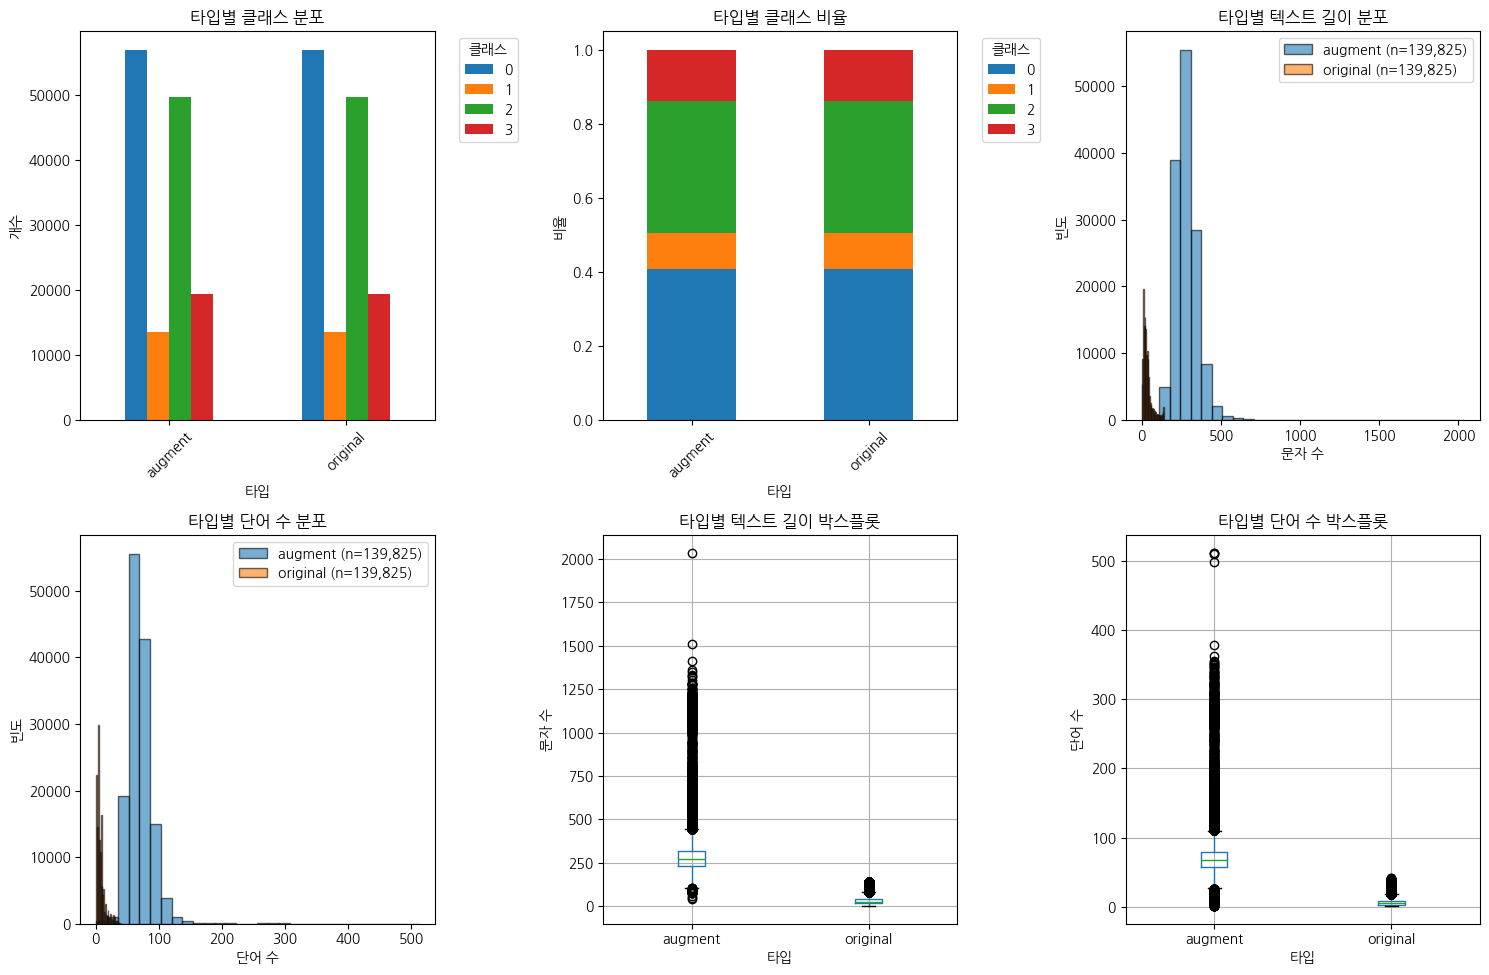

In [ ]:
# 텍스트 길이 및 단어 수 컬럼 생성 (시각화를 위해)
print("텍스트 길이 및 단어 수 컬럼 생성 중...")
df["text_length"] = df["review"].str.len()
df["word_count"] = df["review"].str.split().str.len()
print("✅ 텍스트 길이 및 단어 수 컬럼 생성 완료")

# 타입별 시각화
plt.figure(figsize=(15, 10))

# 1. 타입별 클래스 분포 비교
plt.subplot(2, 3, 1)
type_class_pivot = df.groupby(['type', 'label']).size().unstack(fill_value=0)
type_class_pivot.plot(kind='bar', ax=plt.gca())
plt.title('타입별 클래스 분포')
plt.xlabel('타입')
plt.ylabel('개수')
plt.legend(title='클래스', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# 2. 타입별 클래스 비율 비교 (정규화)
plt.subplot(2, 3, 2)
type_class_pivot_norm = type_class_pivot.div(type_class_pivot.sum(axis=1), axis=0)
type_class_pivot_norm.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('타입별 클래스 비율')
plt.xlabel('타입')
plt.ylabel('비율')
plt.legend(title='클래스', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# 3. 타입별 텍스트 길이 분포
plt.subplot(2, 3, 3)
for data_type in df["type"].unique():
    type_data = df[df["type"] == data_type]
    plt.hist(type_data["text_length"], bins=30, alpha=0.6, 
             label=f"{data_type} (n={len(type_data):,})", edgecolor='black')
plt.title('타입별 텍스트 길이 분포')
plt.xlabel('문자 수')
plt.ylabel('빈도')
plt.legend()

# 4. 타입별 단어 수 분포
plt.subplot(2, 3, 4)
for data_type in df["type"].unique():
    type_data = df[df["type"] == data_type]
    plt.hist(type_data["word_count"], bins=30, alpha=0.6, 
             label=f"{data_type} (n={len(type_data):,})", edgecolor='black')
plt.title('타입별 단어 수 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.legend()

# 5. 타입별 텍스트 길이 박스플롯
plt.subplot(2, 3, 5)
df.boxplot(column='text_length', by='type', ax=plt.gca())
plt.title('타입별 텍스트 길이 박스플롯')
plt.xlabel('타입')
plt.ylabel('문자 수')
plt.suptitle('')  # 기본 제목 제거

# 6. 타입별 단어 수 박스플롯
plt.subplot(2, 3, 6)
df.boxplot(column='word_count', by='type', ax=plt.gca())
plt.title('타입별 단어 수 박스플롯')
plt.xlabel('타입')
plt.ylabel('단어 수')
plt.suptitle('')  # 기본 제목 제거

plt.tight_layout()
plt.show()


In [ ]:
# 타입별 텍스트 품질 분석
print("=" * 50)
print("타입별 텍스트 품질 분석")
print("=" * 50)

for data_type in df["type"].unique():
    type_data = df[df["type"] == data_type]
    print(f"\n[{data_type.upper()} 데이터 품질 분석]")
    
    # 1. Null 값 및 빈 텍스트 확인
    null_count = type_data["review"].isnull().sum()
    empty_texts = type_data["review"].str.strip().eq("").sum()
    whitespace_only = type_data["review"].str.isspace().sum()
    
    print(f"  Null 값: {null_count}개")
    print(f"  빈 텍스트: {empty_texts}개")
    print(f"  공백만 있는 텍스트: {whitespace_only}개")
    
    # 2. 중복 텍스트 확인
    duplicate_count = type_data["review"].duplicated().sum()
    print(f"  중복 리뷰: {duplicate_count}개")
    
    # 3. 특수 문자만으로 구성된 텍스트 확인
    special_char_only = type_data["review"].str.match(r"^[^\w\s가-힣]+$", na=False).sum()
    print(f"  특수문자만 있는 리뷰: {special_char_only}개")
    
    # 4. 숫자만으로 구성된 텍스트 확인
    digit_only = type_data["review"].str.match(r"^\d+$", na=False).sum()
    print(f"  숫자만 있는 리뷰: {digit_only}개")
    
    # 5. 한글이 없는 텍스트 확인
    non_korean = ~type_data["review"].str.contains(r"[가-힣ㄱ-ㅎㅏ-ㅣ]", na=False)
    non_korean_count = non_korean.sum()
    print(f"  한글이 없는 리뷰: {non_korean_count}개")
    
    # 6. 품질 이슈 종합
    total_issues = null_count + empty_texts + whitespace_only + duplicate_count + special_char_only + digit_only + non_korean_count
    print(f"  총 품질 이슈: {total_issues:,}개 ({total_issues/len(type_data)*100:.2f}%)")
    print(f"  양질의 데이터: {len(type_data)-total_issues:,}개 ({(len(type_data)-total_issues)/len(type_data)*100:.2f}%)")

print("\n✅ 타입별 품질 분석 완료")


타입별 텍스트 품질 분석

[AUGMENT 데이터 품질 분석]
  Null 값: 0개
  빈 텍스트: 0개
  공백만 있는 텍스트: 0개
  중복 리뷰: 7개
  특수문자만 있는 리뷰: 0개
  숫자만 있는 리뷰: 0개
  한글이 없는 리뷰: 4개
  총 품질 이슈: 11개 (0.01%)
  양질의 데이터: 139,814개 (99.99%)

[ORIGINAL 데이터 품질 분석]
  Null 값: 6개
  빈 텍스트: 0개
  공백만 있는 텍스트: 0개
  중복 리뷰: 3343개
  특수문자만 있는 리뷰: 88개
  숫자만 있는 리뷰: 64개
  한글이 없는 리뷰: 1038개
  총 품질 이슈: 4,539개 (3.25%)
  양질의 데이터: 135,286개 (96.75%)

✅ 타입별 품질 분석 완료


In [ ]:
# 타입별 샘플 리뷰 분석
print("=" * 50)
print("타입별 샘플 리뷰 분석")
print("=" * 50)

for data_type in df["type"].unique():
    type_data = df[df["type"] == data_type]
    print(f"\n[{data_type.upper()} 데이터 샘플 리뷰]")
    
    # 각 클래스별 샘플 리뷰
    for label in sorted(type_data["label"].unique()):
        print(f"\n  클래스 {label} ({LABEL_MAPPING[label]}) 샘플:")
        samples = type_data[type_data["label"] == label]["review"].head(2)
        for i, sample in enumerate(samples, 1):
            sample_preview = sample[:100] + "..." if len(sample) > 100 else sample
            print(f"    {i}. {sample_preview}")

print("\n✅ 타입별 샘플 리뷰 분석 완료")


타입별 샘플 리뷰 분석

[AUGMENT 데이터 샘플 리뷰]

  클래스 0 (강한 부정) 샘플:
    1. 진짜 이 영화 보다보면 내가 다 암 걸릴 듯. 등장인물들 하나같이 다 정신없고, 짜증나는 전개에 머리가 지끈지끈거려. 도대체 무슨 생각으로 이렇게 만들어놨는지 감독이 궁금할 정도야...
    2. 이 영화 진짜 20대인 내가 보기에도 너무 유치하고 질린다고 느껴졌어요. 스토리 전개도 너무 뻔하고, 예상 가능한 흐름이라서 보는 내내 하품이 나왔어요. 캐릭터들도 개성이 너무 없...

  클래스 1 (약한 부정) 샘플:
    1. 이 영화는 그냥 머리 식히면서 보면 괜찮을 것 같아요. 스토리나 액션 같은 건 별로 기대 안 하고 보면 그래도 나름 재밌는 요소들이 있긴 해요. 특히, 시각효과나 음악 같은 부분들...
    2. 음... 이 영화는 뭔가 계속 보다 보면 나도 모르게 분노가 차오르는 매력이 있긴 해요. 특히 잠이 안 올 때 보면 뭔가 시간을 잘 때울 수 있을 거 같아요. 하지만 전체적으로 보...

  클래스 2 (약한 긍정) 샘플:
    1. 이 영화는 정말 여성의 강인함과 힘을 제대로 보여주는 작품이었어요! 주인공이 자기 자신을 찾아가고, 가부장적인 사회 구조에 맞서는 모습이 너무 멋있었어요. 특히 마지막 장면에서 그...
    2. 크리스마스 시즌엔 무조건 홈 알론이죠! 맥컬리 컬킨이 연기한 케빈의 재치있고 천방지축인 모습을 보면서 웃음꽃이 피지 않은 이가 없을 거예요. 특히 그 두 명의 도둑들과의 에피소드들...

  클래스 3 (강한 긍정) 샘플:
    1. 와... 진짜 제대로 짱입니다 ㅡㅡ! 이 영화 하나로 한 주를 버틸 수 있을 것 같아요. 처음부터 끝까지 눈을 뗄 수가 없었어요. 특히 액션 장면은 진짜 소름 돋을 정도로 멋졌어요...
    2. 와, 이 영화 진짜 대박입니다! 노래 하나하나가 주옥같아서, 극장에서 나올 때까지 계속 흥얼거렸어요 ㅋㅋ 배우들 연기도 미쳤고요, 시대적 상황을 이렇게 잘 녹여낸 스토리에 완벽

In [ ]:
# 타입별 데이터 분할 분석
print("=" * 50)
print("타입별 데이터 분할 분석")
print("=" * 50)

# 타입별 분할 전 분포 확인
print("분할 전 타입별 분포:")
for data_type in df["type"].unique():
    type_count = len(df[df["type"] == data_type])
    type_percentage = type_count / len(df) * 100
    print(f"  {data_type}: {type_count:,}개 ({type_percentage:.1f}%)")

print("\n✅ 타입별 분할 전 분석 완료")


타입별 데이터 분할 분석
분할 전 타입별 분포:
  augment: 139,825개 (50.0%)
  original: 139,825개 (50.0%)

✅ 타입별 분할 전 분석 완료


In [ ]:
# 타입별 자주 등장하는 단어 빈도 분석
print("=" * 50)
print("타입별 자주 등장하는 단어 빈도 분석")
print("=" * 50)

from collections import Counter
import re

def extract_words(text):
    """텍스트에서 단어 추출 (한글, 영문, 숫자 포함)"""
    if pd.isna(text):
        return []
    # 한글, 영문, 숫자만 추출
    words = re.findall(r'[가-힣a-zA-Z0-9]+', str(text))
    return [word.lower() for word in words if len(word) > 1]  # 1글자 단어 제외

# 타입별 단어 빈도 분석
type_word_frequencies = {}

for data_type in df["type"].unique():
    print(f"\n[{data_type.upper()} 타입 단어 빈도 분석]")
    type_data = df[df["type"] == data_type]
    
    # 모든 텍스트에서 단어 추출
    all_words = []
    for text in type_data["review"]:
        words = extract_words(text)
        all_words.extend(words)
    
    # 단어 빈도 계산
    word_counter = Counter(all_words)
    type_word_frequencies[data_type] = word_counter
    
    print(f"  총 단어 수: {len(all_words):,}개")
    print(f"  고유 단어 수: {len(word_counter):,}개")
    print(f"  상위 20개 단어:")
    
    for i, (word, count) in enumerate(word_counter.most_common(20), 1):
        percentage = (count / len(all_words)) * 100
        print(f"    {i:2d}. {word:<15} {count:>6,}회 ({percentage:.2f}%)")

print("\n✅ 타입별 단어 빈도 분석 완료")


타입별 자주 등장하는 단어 빈도 분석

[AUGMENT 타입 단어 빈도 분석]
  총 단어 수: 8,477,733개
  고유 단어 수: 256,687개
  상위 20개 단어:
     1. 진짜              198,360회 (2.34%)
     2. 너무              182,486회 (2.15%)
     3. 정말              134,541회 (1.59%)
     4. 영화              113,322회 (1.34%)
     5. 보는              102,600회 (1.21%)
     6. 영화는             91,666회 (1.08%)
     7. 특히              82,235회 (0.97%)
     8. 보고              82,222회 (0.97%)
     9. 이런              79,408회 (0.94%)
    10. 내내              76,426회 (0.90%)
    11. 영화를             73,959회 (0.87%)
    12. 같아요             59,259회 (0.70%)
    13. 영화가             47,530회 (0.56%)
    14. 배우들의            44,253회 (0.52%)
    15. 그냥              40,905회 (0.48%)
    16. 전혀              34,161회 (0.40%)
    17. 완전              32,437회 (0.38%)
    18. 보면서             31,223회 (0.37%)
    19. 연기도             30,851회 (0.36%)
    20. 정도로             30,244회 (0.36%)

[ORIGINAL 타입 단어 빈도 분석]
  총 단어 수: 1,010,525개
  고유 단어 수: 273,801개
  상위 20개 단어:
     1. 영화         

타입별 단어 사용 패턴 차이점 상세 분석
단어 다양성 지표:
지표                   Original        Augment         차이             
-----------------------------------------------------------------
unique_words         273801.0000     256687.0000     -17114.0000    
total_words          1010525.0000    8477733.0000    7467208.0000   
ttr                  0.2709          0.0303          -0.2407        
simpson_diversity    0.9993          0.9972          -0.0021        
shannon_entropy      15.0227         11.8434         -3.1794        

감정 관련 단어 분석:
카테고리            단어                   Original   Augment    비율차이      
----------------------------------------------------------------------
positive        좋다                   838        111        -0.0816   
positive        좋은                   1619       15282      0.0200    
positive        좋아                   206        732        -0.0118   
positive        재미                   797        720        -0.0704   
positive        재밌                   6          0  

In [ ]:
# 클래스별 어휘 다양성 분석
print("\n클래스별 어휘 다양성:")
for class_name in sorted(df["label"].unique()):
    class_data = df[df["label"] == class_name]
    # 클래스별 전체 텍스트 결합
    all_text = " ".join(class_data["review"].astype(str))
    words = all_text.split()
    unique_words = set(words)

    # Type-Token Ratio (어휘 다양성 지표)
    ttr = len(unique_words) / len(words) if len(words) > 0 else 0

    print(
        f"  {class_name} ({LABEL_MAPPING[class_name]}): 총 단어 {len(words)}개, 고유 단어 {len(unique_words)}개, TTR: {ttr:.3f}"
    )

## 타겟 변수 분석

- 클래스 분포 확인
- 데이터 불균형 확인


어휘 다양성 분석

타입별 어휘 다양성:
  augment: 총 단어 9,775,506개, 고유 단어 320,729개, TTR: 0.033
  original: 총 단어 1,063,304개, 고유 단어 339,030개, TTR: 0.319

클래스별 어휘 다양성:
  0 (강한 부정): 총 단어 4,651,683개, 고유 단어 293,133개, TTR: 0.063
  1 (약한 부정): 총 단어 1,049,950개, 고유 단어 97,455개, TTR: 0.093
  2 (약한 긍정): 총 단어 3,654,003개, 고유 단어 240,734개, TTR: 0.066
  3 (강한 긍정): 총 단어 1,483,174개, 고유 단어 124,439개, TTR: 0.084

타입별 클래스별 어휘 다양성 (교차 분석):

[AUGMENT 타입]
    클래스 0 (강한 부정): 총 단어 4,192,266개, 고유 단어 172,197개, TTR: 0.041
    클래스 1 (약한 부정): 총 단어 964,794개, 고유 단어 70,823개, TTR: 0.073
    클래스 2 (약한 긍정): 총 단어 3,296,698개, 고유 단어 155,889개, TTR: 0.047
    클래스 3 (강한 긍정): 총 단어 1,321,748개, 고유 단어 80,498개, TTR: 0.061

[ORIGINAL 타입]
    클래스 0 (강한 부정): 총 단어 459,417개, 고유 단어 175,294개, TTR: 0.382
    클래스 1 (약한 부정): 총 단어 85,156개, 고유 단어 43,044개, TTR: 0.505
    클래스 2 (약한 긍정): 총 단어 357,305개, 고유 단어 129,911개, TTR: 0.364
    클래스 3 (강한 긍정): 총 단어 161,426개, 고유 단어 66,234개, TTR: 0.410

✅ 어휘 다양성 분석 완료


In [ ]:
# 라벨 매핑 정의
LABEL_MAPPING = {0: "강한 부정", 1: "약한 부정", 2: "약한 긍정", 3: "강한 긍정"}


In [ ]:
# 클래스 분포 분석
class_counts = df["label"].value_counts()
class_percentages = df["label"].value_counts(normalize=True) * 100

print("Class Distribution:")
print(class_counts)
print("\nClass percentages:")
for label, percentage in class_percentages.items():
    print(f"{label} ({LABEL_MAPPING[label]}): {percentage:.2f}%")

# 클래스 불균형 체크
imbalance_ratio = class_percentages.max() / class_percentages.min()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}")
print("⚠️ Imbalanced" if imbalance_ratio > 3 else "✅ Balanced")


Class Distribution:
label
0    114066
2     99416
3     38952
1     27216
Name: count, dtype: int64

Class percentages:
0 (강한 부정): 40.79%
2 (약한 긍정): 35.55%
3 (강한 긍정): 13.93%
1 (약한 부정): 9.73%

Imbalance ratio: 4.19
⚠️ Imbalanced


## 전체 분포

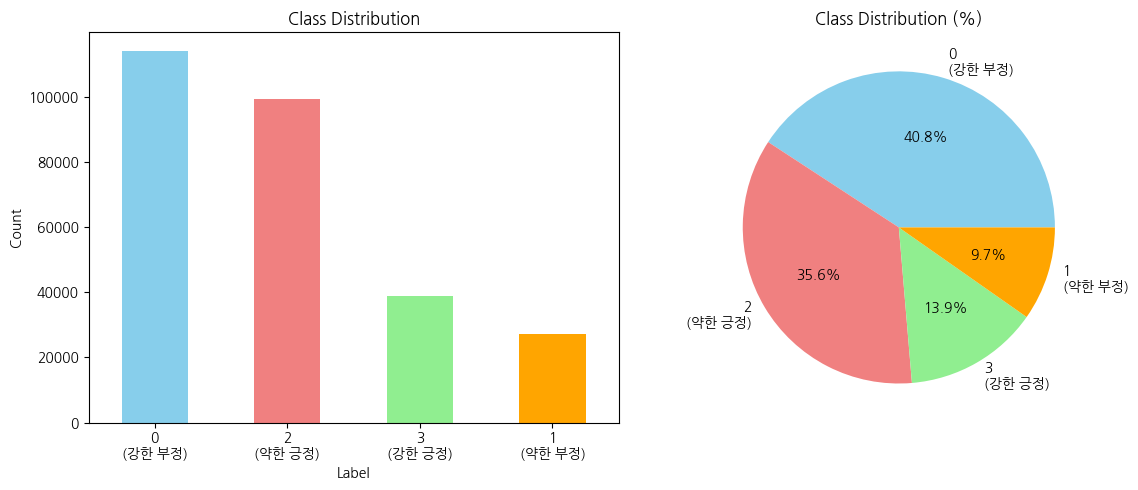

In [ ]:
# 시각화
plt.figure(figsize=(12, 5))
colors = ["skyblue", "lightcoral", "lightgreen", "orange"]

plt.subplot(1, 2, 1)
class_counts.plot(kind="bar", color=colors[: len(class_counts)])
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
# Add label mapping to x-axis
ax = plt.gca()
ax.set_xticklabels(
    [f"{label}\n({LABEL_MAPPING[label]})" for label in class_counts.index]
)

plt.subplot(1, 2, 2)
pie_labels = [f"{label}\n({LABEL_MAPPING[label]})" for label in class_counts.index]
plt.pie(
    class_counts.values,
    labels=pie_labels,
    autopct="%1.1f%%",
    colors=colors[: len(class_counts)],
)
plt.title("Class Distribution (%)")

plt.tight_layout()
plt.show()


## 입력 변수 분석

- 텍스트 길이 확인
- 이상치 탐지


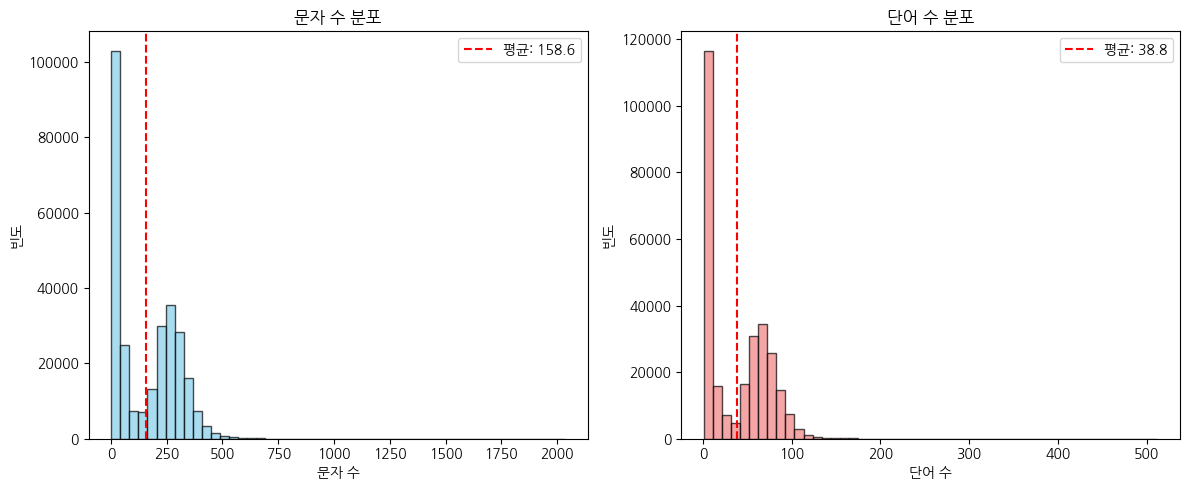

In [ ]:
# 텍스트 길이 분포 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df["text_length"], bins=50, alpha=0.7, color="skyblue", edgecolor="black")
plt.title("문자 수 분포")
plt.xlabel("문자 수")
plt.ylabel("빈도")
plt.axvline(
    df["text_length"].mean(),
    color="red",
    linestyle="--",
    label=f"평균: {df['text_length'].mean():.1f}",
)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df["word_count"], bins=50, alpha=0.7, color="lightcoral", edgecolor="black")
plt.title("단어 수 분포")
plt.xlabel("단어 수")
plt.ylabel("빈도")
plt.axvline(
    df["word_count"].mean(),
    color="red",
    linestyle="--",
    label=f"평균: {df['word_count'].mean():.1f}",
)
plt.legend()

plt.tight_layout()
plt.show()


# EDA (Explanatory Data Analysis)

## 데이터 개요 및 품질 검사

- 데이터셋 형태 및 기본 정보
- 결측값
- 중복값
- 데이터 타입 확인

In [85]:
# 데이터셋 크기 및 기본 정보 확인
print(f"데이터셋 형태: {df.shape}")
print(f"행 수: {df.shape[0]}")
print(f"열 수: {df.shape[1]}")
print(f"열 이름: {list(df.columns)}")

# 결측값 확인
print("\n결측값:")
print(df.isnull().sum())

# 중복값 확인
print(f"\n중복 리뷰: {df['review'].duplicated().sum()}")
print(f"중복 행: {df.duplicated().sum()}")

if df["review"].duplicated().sum() > 0:
    print("\n중복된 리뷰 예시:")
    duplicated_reviews = df[df["review"].duplicated(keep=False)].sort_values("review")
    print(duplicated_reviews[["review", "label"]].head(10))

# 데이터 타입 확인
print("\n데이터 타입:")
print(df.dtypes)

데이터셋 형태: (279650, 4)
행 수: 279650
열 수: 4
열 이름: ['ID', 'review', 'label', 'type']

결측값:
ID        0
review    6
label     0
type      0
dtype: int64

중복 리뷰: 3350
중복 행: 0

중복된 리뷰 예시:
       review  label
112658      !      2
197409      !      0
235169    -_-      0
85131     -_-      0
140661    -_-      0
35114       0      1
187569      0      1
159660     0점      0
217122     0점      0
209801     0점      0

데이터 타입:
ID         int64
review    object
label      int64
type      object
dtype: object


## 타겟 변수 분석

- 클래스 분포 확인
- 데이터 불균형 확인

In [86]:
# 라벨 매핑 정의
LABEL_MAPPING = {0: "강한 부정", 1: "약한 부정", 2: "약한 긍정", 3: "강한 긍정"}

In [87]:
# 클래스 분포 분석
class_counts = df["label"].value_counts()
class_percentages = df["label"].value_counts(normalize=True) * 100

print("Class Distribution:")
print(class_counts)
print("\nClass percentages:")
for label, percentage in class_percentages.items():
    print(f"{label} ({LABEL_MAPPING[label]}): {percentage:.2f}%")

# 클래스 불균형 체크
imbalance_ratio = class_percentages.max() / class_percentages.min()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}")
print("⚠️ Imbalanced" if imbalance_ratio > 3 else "✅ Balanced")

Class Distribution:
label
0    114066
2     99416
3     38952
1     27216
Name: count, dtype: int64

Class percentages:
0 (강한 부정): 40.79%
2 (약한 긍정): 35.55%
3 (강한 긍정): 13.93%
1 (약한 부정): 9.73%

Imbalance ratio: 4.19
⚠️ Imbalanced


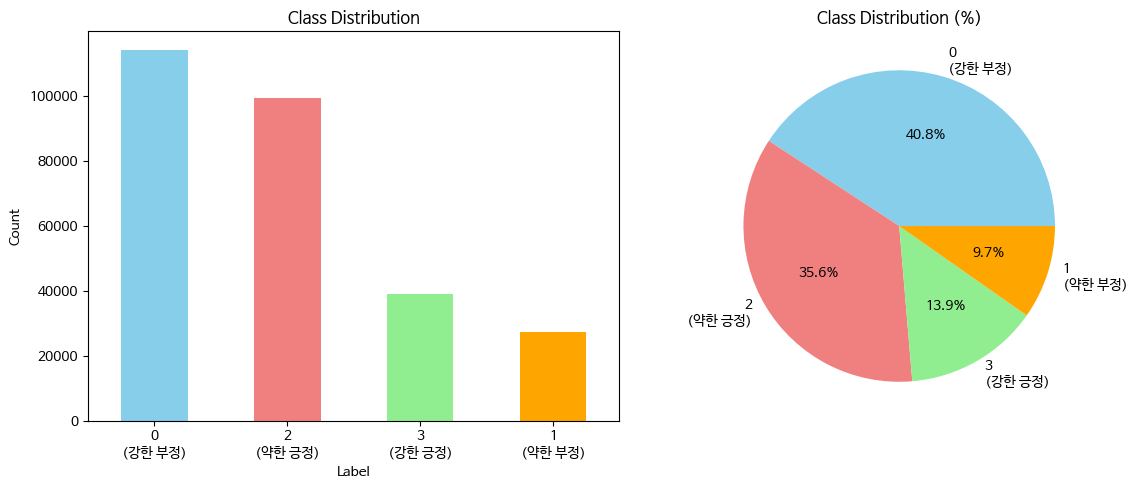

In [88]:
# 시각화
plt.figure(figsize=(12, 5))
colors = ["skyblue", "lightcoral", "lightgreen", "orange"]

plt.subplot(1, 2, 1)
class_counts.plot(kind="bar", color=colors[: len(class_counts)])
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
# Add label mapping to x-axis
ax = plt.gca()
ax.set_xticklabels(
    [f"{label}\n({LABEL_MAPPING[label]})" for label in class_counts.index]
)

plt.subplot(1, 2, 2)
pie_labels = [f"{label}\n({LABEL_MAPPING[label]})" for label in class_counts.index]
plt.pie(
    class_counts.values,
    labels=pie_labels,
    autopct="%1.1f%%",
    colors=colors[: len(class_counts)],
)
plt.title("Class Distribution (%)")

plt.tight_layout()
plt.show()

## 입력 변수 분석

- 텍스트 길이 확인
- 이상치 탐지

In [89]:
# 텍스트 길이 분석
df["text_length"] = df["review"].str.len()
df["word_count"] = df["review"].str.split().str.len()

print("텍스트 길이 통계:")
print(f"문자 수: {df['text_length'].describe()}")
print(f"단어 수: {df['word_count'].describe()}")

텍스트 길이 통계:
문자 수: count    279644.000000
mean        158.645210
std         137.147273
min           1.000000
25%          27.000000
50%         140.000000
75%         272.000000
max        2035.000000
Name: text_length, dtype: float64
단어 수: count    279644.000000
mean         38.759294
std          34.666607
min           1.000000
25%           6.000000
50%          33.000000
75%          68.000000
max         512.000000
Name: word_count, dtype: float64


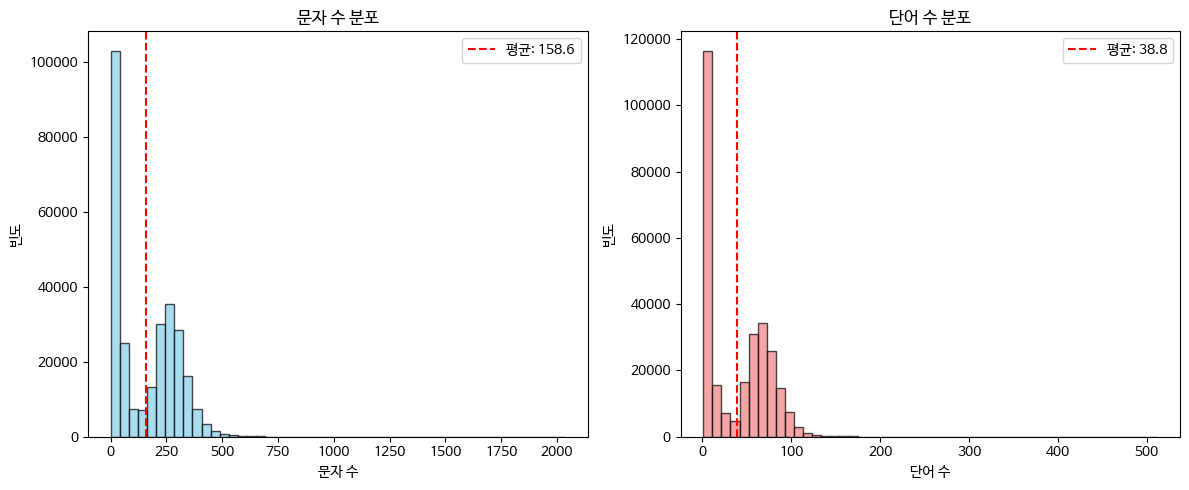

In [90]:
# 텍스트 길이 분포 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df["text_length"], bins=50, alpha=0.7, color="skyblue", edgecolor="black")
plt.title("문자 수 분포")
plt.xlabel("문자 수")
plt.ylabel("빈도")
plt.axvline(
    df["text_length"].mean(),
    color="red",
    linestyle="--",
    label=f"평균: {df['text_length'].mean():.1f}",
)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df["word_count"], bins=50, alpha=0.7, color="lightcoral", edgecolor="black")
plt.title("단어 수 분포")
plt.xlabel("단어 수")
plt.ylabel("빈도")
plt.axvline(
    df["word_count"].mean(),
    color="red",
    linestyle="--",
    label=f"평균: {df['word_count'].mean():.1f}",
)
plt.legend()

plt.tight_layout()
plt.show()

In [91]:
# 이상치 탐지 (매우 짧거나 긴 텍스트)
short_threshold = 10
long_threshold = 100

short_count = (df["text_length"] < short_threshold).sum()
long_count = (df["text_length"] > long_threshold).sum()

print(
    f"\n이상치: 짧은 리뷰(<{short_threshold}자) {short_count}개, 긴 리뷰(>{long_threshold}자) {long_count}개"
)

# 짧은 리뷰 예시 확인
if short_count > 0:
    short_reviews = df[df["text_length"] < short_threshold]
    print("\n짧은 리뷰 예시 (상위 5개):")
    for i, (idx, row) in enumerate(short_reviews.head(5).iterrows(), 1):
        print(
            f"  {i}. '{row['review']}' (길이: {row['text_length']}자, 라벨: {row['label']})"
        )

# 긴 리뷰 예시 확인
if long_count > 0:
    long_reviews = df[df["text_length"] > long_threshold]
    print("\n긴 리뷰 예시 (상위 3개):")
    for i, (idx, row) in enumerate(long_reviews.head(3).iterrows(), 1):
        preview = (
            row["review"][:100] + "..." if len(row["review"]) > 100 else row["review"]
        )
        print(
            f"  {i}. '{preview}' (길이: {row['text_length']}자, 라벨: {row['label']})"
        )


이상치: 짧은 리뷰(<10자) 12097개, 긴 리뷰(>100자) 147918개

짧은 리뷰 예시 (상위 5개):
  1. '싸물고 보자' (길이: 6.0자, 라벨: 2)
  2. '진짜 별로다' (길이: 6.0자, 라벨: 0)
  3. '무가치' (길이: 3.0자, 라벨: 0)
  4. '재미없다' (길이: 4.0자, 라벨: 0)
  5. '정점의 전쟁영화' (길이: 8.0자, 라벨: 2)

긴 리뷰 예시 (상위 3개):
  1. '이 영화는 정말 여성의 강인함과 힘을 제대로 보여주는 작품이었어요! 주인공이 자기 자신을 찾아가고, 가부장적인 사회 구조에 맞서는 모습이 너무 멋있었어요. 특히 마지막 장면에서 그...' (길이: 280.0자, 라벨: 2)
  2. '크리스마스 시즌엔 무조건 홈 알론이죠! 맥컬리 컬킨이 연기한 케빈의 재치있고 천방지축인 모습을 보면서 웃음꽃이 피지 않은 이가 없을 거예요. 특히 그 두 명의 도둑들과의 에피소드들...' (길이: 252.0자, 라벨: 2)
  3. '진짜 이 영화 보다보면 내가 다 암 걸릴 듯. 등장인물들 하나같이 다 정신없고, 짜증나는 전개에 머리가 지끈지끈거려. 도대체 무슨 생각으로 이렇게 만들어놨는지 감독이 궁금할 정도야...' (길이: 252.0자, 라벨: 0)


## 텍스트 품질 평가

- 비어있거나 null인 텍스트 확인
- 잠재적인 데이터 품질 문제 식별
- 언어 일관성 확인

In [92]:
# 1. Null 값 및 빈 텍스트 확인
null_count = df["review"].isnull().sum()
empty_texts = df["review"].str.strip().eq("").sum()
whitespace_only = df["review"].str.isspace().sum()

print(f"Null 값: {null_count}개")
print(f"빈 텍스트: {empty_texts}개")
print(f"공백만 있는 텍스트: {whitespace_only}개")

# 2. 잠재적인 데이터 품질 문제 식별
# 2-1. 중복 텍스트 확인 - 동일한 리뷰가 여러 번 등장하는지 확인
duplicate_count = df["review"].duplicated().sum()
print(f"중복 리뷰: {duplicate_count}개")

# 2-2. 특수 문자만으로 구성된 텍스트 확인 - 의미있는 내용이 없는 리뷰 탐지
special_char_only = df["review"].str.match(r"^[^\w\s가-힣]+$", na=False).sum()
print(f"특수문자만 있는 리뷰: {special_char_only}개")

# 2-3. 숫자만으로 구성된 텍스트 확인 - 평점이나 의미없는 숫자로만 이루어진 리뷰 탐지
digit_only = df["review"].str.match(r"^\d+$", na=False).sum()
print(f"숫자만 있는 리뷰: {digit_only}개")

# 3. 언어 일관성 확인 (한국어 데이터셋 특성)
# 한글이 포함되지 않은 텍스트 확인 - 완성형 한글, 자음, 모음 모두 포함하여 검사
non_korean = ~df["review"].str.contains(r"[가-힣ㄱ-ㅎㅏ-ㅣ]", na=False)
non_korean_count = non_korean.sum()
print(f"한글이 없는 리뷰: {non_korean_count}개")

# 데이터 품질 종합 요약
print("\n=== 데이터 품질 종합 요약 ===")
total_issues = (
    null_count
    + empty_texts
    + whitespace_only
    + duplicate_count
    + special_char_only
    + digit_only
    + non_korean_count
)
print(f"전체 리뷰 수: {len(df):,}")
print(f"품질 이슈가 있는 리뷰 수: {total_issues:,}")
print(f"품질 이슈 비율: {total_issues / len(df) * 100:.2f}%")
print(f"양질의 데이터 비율: {(len(df) - total_issues) / len(df) * 100:.2f}%")

Null 값: 6개
빈 텍스트: 0개
공백만 있는 텍스트: 0개
중복 리뷰: 3350개
특수문자만 있는 리뷰: 88개
숫자만 있는 리뷰: 64개
한글이 없는 리뷰: 1042개

=== 데이터 품질 종합 요약 ===
전체 리뷰 수: 279,650
품질 이슈가 있는 리뷰 수: 4,550
품질 이슈 비율: 1.63%
양질의 데이터 비율: 98.37%


In [93]:
# 상세한 예시를 보고 싶으면 True로 변경하세요
VERBOSE = True

# 데이터 품질 분석 결과를 예시로 확인해보기
if VERBOSE:
    print("\n=== 데이터 품질 이슈 예시 ===")

    # 중복 리뷰 예시 (3개)
    duplicated_reviews = df[df["review"].duplicated(keep=False)]
    if not duplicated_reviews.empty:
        print(f"\n중복 리뷰 예시 (전체 {len(duplicated_reviews)}개 중 3개):")
        for i, (idx, row) in enumerate(duplicated_reviews.head(3).iterrows()):
            print(f"  {i + 1}. ID {row['ID']}: {row['review']}")
    else:
        print("\n중복 리뷰가 없습니다.")

    # 특수문자만 있는 리뷰 예시 (3개)
    special_char_reviews = df[df["review"].str.match(r"^[^\w\s가-힣]+$", na=False)]
    if not special_char_reviews.empty:
        print(
            f"\n특수문자만 있는 리뷰 예시 (전체 {len(special_char_reviews)}개 중 3개):"
        )
        for i, (idx, row) in enumerate(special_char_reviews.head(3).iterrows()):
            print(f"  {i + 1}. ID {row['ID']}: '{row['review']}'")
    else:
        print("\n특수문자만 있는 리뷰가 없습니다.")

    # 숫자만 있는 리뷰 예시 (3개)
    digit_only_reviews = df[df["review"].str.match(r"^\d+$", na=False)]
    if not digit_only_reviews.empty:
        print(f"\n숫자만 있는 리뷰 예시 (전체 {len(digit_only_reviews)}개 중 3개):")
        for i, (idx, row) in enumerate(digit_only_reviews.head(3).iterrows()):
            print(f"  {i + 1}. ID {row['ID']}: '{row['review']}'")
    else:
        print("\n숫자만 있는 리뷰가 없습니다.")

    # 한글이 없는 리뷰 예시 (3개)
    non_korean_reviews = df[~df["review"].str.contains(r"[가-힣ㄱ-ㅎㅏ-ㅣ]", na=False)]
    if not non_korean_reviews.empty:
        print(f"\n한글이 없는 리뷰 예시 (전체 {len(non_korean_reviews)}개 중 3개):")
        for i, (idx, row) in enumerate(non_korean_reviews.head(3).iterrows()):
            print(f"  {i + 1}. ID {row['ID']}: '{row['review']}'")
    else:
        print("\n한글이 없는 리뷰가 없습니다.")
else:
    print("\n상세한 예시를 보려면 VERBOSE = True로 변경하여 셀을 다시 실행하세요.")


=== 데이터 품질 이슈 예시 ===

중복 리뷰 예시 (전체 4398개 중 3개):
  1. ID 134: 재미없다
  2. ID 171: 볼만했다.
  3. ID 172: 굳

특수문자만 있는 리뷰 예시 (전체 88개 중 3개):
  1. ID 3439: ';;'
  2. ID 3685: '...?.?...??....'
  3. ID 14300: '"'

숫자만 있는 리뷰 예시 (전체 64개 중 3개):
  1. ID 1722: '1234567890'
  2. ID 5232: '2'
  3. ID 11775: '1'

한글이 없는 리뷰 예시 (전체 1042개 중 3개):
  1. ID 123: 'good good!^^'
  2. ID 1722: '1234567890'
  3. ID 2094: 'Very interesting'


## 클래스별 텍스트 특성

- 클래스별 리뷰 검토
- 클래스별 평균 텍스트 길이
- 클래스별 어휘 다양성
- 클래스별 공통 패턴이나 키워드

In [94]:
# 각 클래스별 샘플 리뷰 검토
print("각 클래스별 샘플 리뷰:")
for label in df["label"].unique():
    print(f"\n[{label}] {LABEL_MAPPING[label]} 샘플:")
    samples = df[df["label"] == label]["review"].head(2)
    for i, sample in enumerate(samples, 1):
        print(f"  {i}. {sample[:100]}{'...' if len(sample) > 100 else ''}")

각 클래스별 샘플 리뷰:

[2] 약한 긍정 샘플:
  1. 이 영화는 정말 여성의 강인함과 힘을 제대로 보여주는 작품이었어요! 주인공이 자기 자신을 찾아가고, 가부장적인 사회 구조에 맞서는 모습이 너무 멋있었어요. 특히 마지막 장면에서 그...
  2. 크리스마스 시즌엔 무조건 홈 알론이죠! 맥컬리 컬킨이 연기한 케빈의 재치있고 천방지축인 모습을 보면서 웃음꽃이 피지 않은 이가 없을 거예요. 특히 그 두 명의 도둑들과의 에피소드들...

[1] 약한 부정 샘플:
  1. 어느 부잣집 도련님의 철없는 행각
  2. 리얼과 스케일은 있다. 하지만 영화적인 재미는 없는것이 문제

[0] 강한 부정 샘플:
  1. 왜이렇게 재미가없냐 원도 별로였지만 원보다 더 재미없네
  2. 참나ㅋㅋ이게 무슨 드라마 최초 뮤지컬드라마야 이게무슨ㅋㅋ걍 다른 드라마랑 똑같구만 사랑이야기만 하고 삼각관계에 난또 뮤지컬드라마라 해서 드림하이처럼 노래로 승부하는 줄알앗더니ㅋㅋ

[3] 강한 긍정 샘플:
  1. 와... 진짜 제대로 짱입니다 ㅡㅡ! 이 영화 하나로 한 주를 버틸 수 있을 것 같아요. 처음부터 끝까지 눈을 뗄 수가 없었어요. 특히 액션 장면은 진짜 소름 돋을 정도로 멋졌어요...
  2. 와, 이 영화 진짜 대박입니다! 노래 하나하나가 주옥같아서, 극장에서 나올 때까지 계속 흥얼거렸어요 ㅋㅋ 배우들 연기도 미쳤고요, 시대적 상황을 이렇게 잘 녹여낸 스토리에 완벽한 ...


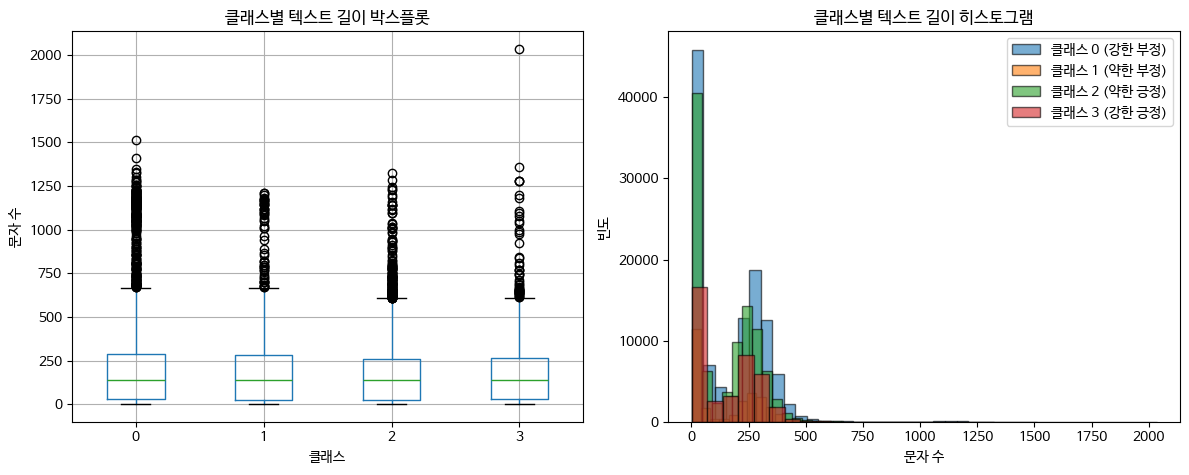

In [95]:
# 클래스별 텍스트 길이 분포 분석
plt.figure(figsize=(12, 5))

# 박스플롯
plt.subplot(1, 2, 1)
df.boxplot(column="text_length", by="label", ax=plt.gca())
plt.title("클래스별 텍스트 길이 박스플롯")
plt.xlabel("클래스")
plt.ylabel("문자 수")
plt.suptitle("")  # 기본 제목 제거

# 각 클래스별 히스토그램
plt.subplot(1, 2, 2)
for label in sorted(df["label"].unique()):
    class_data = df[df["label"] == label]
    plt.hist(
        class_data["text_length"],
        bins=30,
        alpha=0.6,
        label=f"클래스 {label} ({LABEL_MAPPING[label]})",
        edgecolor="black",
    )
plt.title("클래스별 텍스트 길이 히스토그램")
plt.xlabel("문자 수")
plt.ylabel("빈도")
plt.legend()

plt.tight_layout()
plt.show()

In [96]:
# 클래스별 어휘 다양성 분석
print("\n클래스별 어휘 다양성:")
for class_name in sorted(df["label"].unique()):
    class_data = df[df["label"] == class_name]
    # 클래스별 전체 텍스트 결합
    all_text = " ".join(class_data["review"].astype(str))
    words = all_text.split()
    unique_words = set(words)

    # Type-Token Ratio (어휘 다양성 지표)
    ttr = len(unique_words) / len(words) if len(words) > 0 else 0

    print(
        f"  {class_name} ({LABEL_MAPPING[class_name]}): 총 단어 {len(words)}개, 고유 단어 {len(unique_words)}개, TTR: {ttr:.3f}"
    )


클래스별 어휘 다양성:
  0 (강한 부정): 총 단어 4651683개, 고유 단어 293133개, TTR: 0.063
  1 (약한 부정): 총 단어 1049950개, 고유 단어 97455개, TTR: 0.093
  2 (약한 긍정): 총 단어 3654003개, 고유 단어 240734개, TTR: 0.066
  3 (강한 긍정): 총 단어 1483174개, 고유 단어 124439개, TTR: 0.084


In [97]:
# 클래스별 공통 키워드 분석
print("\n클래스별 상위 빈출 단어 (불용어 제외):")

# 한국어 불용어 리스트 확장
stopwords = [
    # "은",
    # "는",
    # "이",
    # "가",
    # "을",
    # "를",
    # "의",
    # "에",
    # "와",
    # "과",
    # "도",
    # "로",
    # "으로",
    # "에서",
    # "한",
    # "그",
    # "것",
    # "그것",
    # "이것",
    # "저것",
    # "그리고",
    # "그런데",
    # "하지만",
    # "그러나",
    # "있다",
    # "없다",
    # "되다",
    # "하다",
    # "이다",
    # "아니다",
    # "같다",
    # "많다",
    # "좋다",
    # "나쁘다",
    # "수",
    # "때",
    # "곳",
    # "사람",
    # "것들",
    # "정말",
    # "너무",
    # "매우",
    # "아주",
    # "참",
    # "좀",
]

for class_name in sorted(df["label"].unique()):
    class_data = df[df["label"] == class_name]
    all_text = " ".join(class_data["review"].astype(str))

    # 단어 추출 및 필터링 (길이 2 이상, 불용어 제외)
    words = [
        word
        for word in all_text.split()
        if word not in stopwords and len(word) >= 2 and word.isalpha()
    ]

    # 단어 빈도 계산
    word_counts = Counter(words)
    top_words = word_counts.most_common(10)  # 상위 10개로 지정

    print(
        f"\n{class_name} ({LABEL_MAPPING[class_name]}) - 총 {len(class_data)}개 샘플:"
    )
    for i, (word, count) in enumerate(top_words, 1):
        percentage = (count / len(words)) * 100 if len(words) > 0 else 0
        print(f"  {i:2d}. '{word}': {count}회 ({percentage:.1f}%)")


클래스별 상위 빈출 단어 (불용어 제외):

0 (강한 부정) - 총 114066개 샘플:
   1. '너무': 106022회 (3.2%)
   2. '진짜': 82753회 (2.5%)
   3. '보는': 55270회 (1.7%)
   4. '정말': 52786회 (1.6%)
   5. '이런': 52545회 (1.6%)
   6. '영화': 49829회 (1.5%)
   7. '영화는': 44978회 (1.4%)
   8. '보고': 44776회 (1.4%)
   9. '영화를': 40348회 (1.2%)
  10. '내내': 39208회 (1.2%)

1 (약한 부정) - 총 27216개 샘플:
   1. '너무': 16454회 (2.2%)
   2. '보고': 10499회 (1.4%)
   3. 'ㅠㅠ': 8538회 (1.1%)
   4. '뭔가': 7251회 (1.0%)
   5. '영화': 7061회 (0.9%)
   6. '보는': 6857회 (0.9%)
   7. '진짜': 6833회 (0.9%)
   8. '정말': 6658회 (0.9%)
   9. '그냥': 6467회 (0.9%)
  10. '영화는': 6200회 (0.8%)

2 (약한 긍정) - 총 99416개 샘플:
   1. '진짜': 60021회 (2.3%)
   2. '정말': 56003회 (2.1%)
   3. '너무': 45092회 (1.7%)
   4. '영화': 34369회 (1.3%)
   5. '보는': 29527회 (1.1%)
   6. '특히': 28620회 (1.1%)
   7. '영화는': 26255회 (1.0%)
   8. '내내': 22921회 (0.9%)
   9. '영화를': 20993회 (0.8%)
  10. '보고': 19278회 (0.7%)

3 (강한 긍정) - 총 38952개 샘플:
   1. '진짜': 46041회 (4.4%)
   2. '정말': 24398회 (2.3%)
   3. '너무': 22577회 (2.2%)
   4. '영화': 17

# Data/Feature Engineering

## 텍스트 전처리 및 정리

- 기본 텍스트 정리 (특수문자 제거, 공백 정규화)
- 필요시 한국어 특화 전처리 처리
- 매우 짧거나 긴 텍스트 제거 또는 처리
- 중복 제거

In [98]:
# 데이터 전처리를 위한 복사본 생성
df_processed = df[["ID", "label", "review"]].copy()

print(f"원본 데이터셋 크기: {len(df_processed):,}개")

df_processed.head()

원본 데이터셋 크기: 279,650개


,ID,label,review
0,0,2,이 영화는 정말 여성의 강인함과 힘을 제대로 보여주는 작품이었어요! 주인공이 자기 ...
1,1,1,어느 부잣집 도련님의 철없는 행각
2,3,0,왜이렇게 재미가없냐 원도 별로였지만 원보다 더 재미없네
3,4,2,크리스마스 시즌엔 무조건 홈 알론이죠! 맥컬리 컬킨이 연기한 케빈의 재치있고 천방지...
4,5,0,참나ㅋㅋ이게 무슨 드라마 최초 뮤지컬드라마야 이게무슨ㅋㅋ걍 다른 드라마랑 똑같구만 ...


In [99]:
def clean_data_quality(df, text_col='review', label_col='label', id_col='ID'):
    """
    데이터 품질 검사 및 문제가 있는 데이터 제거
    
    Args:
        df: 원본 데이터프레임
        text_col: 텍스트 컬럼명
        label_col: 라벨 컬럼명  
        id_col: ID 컬럼명
    
    Returns:
        clean_df: 품질 문제가 제거된 데이터프레임
        removed_info: 제거된 데이터 정보
    """
    print(f"원본 데이터 수: {len(df):,}개")
    
    # 1. 품질 검사
    null_mask = df[text_col].isnull()
    empty_mask = df[text_col].str.strip().eq("")
    whitespace_mask = df[text_col].str.isspace()
    duplicate_mask = df[text_col].duplicated()
    digit_only_mask = df[text_col].str.match(r"^\d+$", na=False)
    
    print(f"Null 값: {null_mask.sum()}개")
    print(f"빈 텍스트: {empty_mask.sum()}개") 
    print(f"공백만 있는 텍스트: {whitespace_mask.sum()}개")
    print(f"중복 리뷰: {duplicate_mask.sum()}개")
    print(f"숫자만 있는 리뷰: {digit_only_mask.sum()}개")
    
    # 2. 품질 문제가 있는 데이터 마스크 생성
    quality_issues_mask = (
        null_mask | 
        empty_mask | 
        whitespace_mask | 
        duplicate_mask | 
        digit_only_mask 
    )
    
    # 3. 품질 문제가 있는 데이터 제거
    clean_df = df[~quality_issues_mask].copy().reset_index(drop=True)
    removed_count = quality_issues_mask.sum()
    
    print(f"\n=== 데이터 품질 검사 결과 ===")
    print(f"제거된 데이터: {removed_count:,}개")
    print(f"남은 데이터: {len(clean_df):,}개")
    print(f"데이터 품질 비율: {len(clean_df) / len(df) * 100:.2f}%")
    
    # 4. 제거된 데이터의 상세 정보 출력
    if removed_count > 0:
        print(f"\n=== 제거된 데이터 상세 정보 ===")
        removed_data = df[quality_issues_mask]
        
        if null_mask.sum() > 0:
            print(f"Null 값 샘플: {removed_data[null_mask][text_col].head(3).tolist()}")
        if empty_mask.sum() > 0:
            print(f"빈 텍스트 샘플: {removed_data[empty_mask][text_col].head(3).tolist()}")
        if whitespace_mask.sum() > 0:
            print(f"공백만 있는 텍스트 샘플: {removed_data[whitespace_mask][text_col].head(3).tolist()}")
        if duplicate_mask.sum() > 0:
            print(f"중복 리뷰 샘플: {removed_data[duplicate_mask][text_col].head(3).tolist()}")
        if digit_only_mask.sum() > 0:
            print(f"숫자만 있는 리뷰 샘플: {removed_data[digit_only_mask][text_col].head(3).tolist()}")
    
    # 5. 제거된 데이터 정보 저장
    removed_info = {
        'total_removed': removed_count,
        'null_count': null_mask.sum(),
        'empty_count': empty_mask.sum(),
        'whitespace_count': whitespace_mask.sum(),
        'duplicate_count': duplicate_mask.sum(),
        'digit_only_count': digit_only_mask.sum()
    }
    
    return clean_df, removed_info

print("✅ 데이터 품질 검사 및 제거 함수 정의 완료")

✅ 데이터 품질 검사 및 제거 함수 정의 완료


In [100]:
df_processed, removed_info = clean_data_quality(df_processed)

print(f"\n원본 데이터: {len(df_processed):,}개")
print(f"정제된 데이터: {len(df_clean):,}개")
print(f"제거된 데이터: {removed_info['total_removed']:,}개")

원본 데이터 수: 279,650개


Null 값: 6개
빈 텍스트: 0개
공백만 있는 텍스트: 0개
중복 리뷰: 3350개
숫자만 있는 리뷰: 64개

=== 데이터 품질 검사 결과 ===
제거된 데이터: 3,379개
남은 데이터: 276,271개
데이터 품질 비율: 98.79%

=== 제거된 데이터 상세 정보 ===
Null 값 샘플: [nan, nan, nan]
중복 리뷰 샘플: ['재미없다', '굳', 'tv 전기세가 아깝다!!!']
숫자만 있는 리뷰 샘플: ['1234567890', '2', '1']

원본 데이터: 276,271개
정제된 데이터: 276,271개
제거된 데이터: 3,379개


## 텍스트 정규화

- 대소문자 정규화 (BERT가 처리하지만)
- 구두점 처리
- 특수문자 처리
- URL/이메일/멘션 정리 (있는 경우)

## 텍스트 전처리 파이프라인 재구성

- 앞서 정의한 전처리 및 정규화 함수들을 활용하여 재사용 가능한 파이프라인 구성
- 또한 학습/검증 데이터 분리 시 데이터 누수(Data Leakage)를 방지하기 위한 전략 포함

데이터 누수 방지 전략:
- 전처리 파라미터는 학습 데이터에서만 학습
- 검증/테스트 데이터는 학습된 파라미터로만 변환
- 레이블 정보를 활용한 전처리는 학습 시에만 적용

In [101]:
# 텍스트 전처리 파이프라인 클래스 구성
class TextPreprocessingPipeline:
    """
    텍스트 전처리 파이프라인 클래스
    - 기본 전처리와 학습 데이터 기반 고급 전처리를 통합 관리
    - 재사용 가능하고 확장 가능한 구조
    """

    def __init__(self):
        self.is_fitted = False
        self.vocab_info = {}
        self.label_patterns = {}

    def basic_preprocess(self, texts):
        """기본 전처리 (clean_text + normalize 기능)"""
        processed_texts = []
        for text in texts:
            # 기본 텍스트 정리
            cleaned = self._clean_text(text)
            processed_texts.append(cleaned)
        return processed_texts

    def _clean_text(self, text):
        """기존 clean_text 함수 내용"""
        if pd.isna(text):
            return ""

        text = str(text).strip()
        text = text.lower() # 소문자 변환
        text = self._remove_urls_emails_mentions(text) # URL, 이메일, 멘션 제거
        text = self._normalize_punctuation(text)  # 구두점 정규화
        #text = self._remove_incomplete_korean(text)
        text = self._normalize_emotion_expressions(text) # 감정 표현 정규화 (ㅋㅋㅋ , ㅎㅎㅎ)
        text = self._reduce_excessive_repetition(text) # 과도한 문자 반복 축소 (아아아아아아앙 -> 아아아아)
        text = self._clean_special_characters(text) # 특수문자 제거 (이모티콘, 특수기호)
        text = self._normalize_whitespace(text) # 공백 정규화 (여러 개의 공백 -> 하나의 공백)

        return text.strip()

    def fit(self, texts, labels=None):
        """학습 데이터로부터 전처리 정보 학습 (품질 검사 기준 학습)"""

        self.is_fitted = True
        print("✓ 전처리 파이프라인 학습 완료")


    def transform(self, texts):
        """전처리 적용 (품질 문제 데이터 제거 + 텍스트 전처리)"""
        if not self.is_fitted:
            print(
                "Warning: 파이프라인이 학습되지 않았습니다. 기본 전처리만 적용합니다."
            )
            return self.basic_preprocess(texts)
        
        # 텍스트 전처리 적용
        return self.basic_preprocess(texts)

    def fit_transform(self, texts, labels=None):
        """학습과 변환을 동시에 수행"""
        # 1. 학습 단계 (품질 검사 기준 학습)
        self.fit(texts, labels)
        
        # 2. 변환 단계 (품질 문제 데이터 제거 + 텍스트 전처리)
        processed_texts = self.transform(texts)
        
        # 3. 라벨도 동일하게 필터링
        return processed_texts


    @staticmethod
    def _remove_incomplete_korean(text):
        """불완전한 한글 제거 (자음/모음만 있는 경우)"""
        return re.sub(r"[ㄱ-ㅎㅏ-ㅣ]+", "", text)

    @staticmethod
    def _normalize_emotion_expressions(text):
        """감정 표현 정규화"""
        def replace_emotion(match):
            char = match.group(1)
            count = len(match.group(0))
            # log2x + 1 공식을 정수로 변환
            new_count = int(math.log2(count)) + 1 if count > 0 else 1
            return char * new_count
        
        # 웃음과 슬픔 표현 정규화 (2번 이상 반복)
        text = re.sub(r"([ㅋㅎ])\1+", replace_emotion, text)
        text = re.sub(r"([ㅠㅜㅡ])\1+", replace_emotion, text)
        return text

    @staticmethod
    def _reduce_excessive_repetition(text):
        """과도한 문자 반복 축소 (4번 이상 → 3번으로)"""
        
        def replace_repetition(match):
            char = match.group(1)
            count = len(match.group(0))
            # log2x + 1 공식을 정수로 변환하고 최소 1개 보장
            new_count = max(1, int(math.log2(count)) + 1) if count > 0 else 1
            return char * new_count
        
        return re.sub(r"(.)\1{3,}", replace_repetition, text)

    @staticmethod
    def _clean_special_characters(text):
        """특수문자 제거 (이모티콘 보존)"""

        # 1. 허용할 이모티콘 범위 정의
        # emoji_ranges = r"\U0001F600-\U0001F64F"  # Emoticons
        # emoji_ranges += r"\U0001F300-\U0001F5FF"  # Misc Symbols/Pictographs
        # emoji_ranges += r"\U0001F680-\U0001F6FF"  # Transport/Map
        # emoji_ranges += r"\U00002600-\U000026FF"  # Misc Symbols (★ 포함)
        # emoji_ranges += r"\U00002700-\U000027BF"  # Dingbats

        # 2. 허용할 기타 특수기호 정의
        other_symbols = r"@★#$" # 예시로 @ 추가

        # 3. 허용할 문자들을 조합하여 정규식 생성
        #allowed_chars = rf"\w\s가-힣.,!?ㅋㅎㅠㅜㅡ~\-{emoji_ranges}{other_symbols}"
        allowed_chars = rf"\w\s가-힣.,!?ㅋㅎㅠㅜㅡ~\-"
        
        return re.sub(rf"[^{allowed_chars}]", " ", text)
 
 
    @staticmethod
    def _normalize_whitespace(text):
        """공백 정규화"""
        return re.sub(r"\s+", " ", text)

    @staticmethod
    def _normalize_punctuation(text):
        """구두점 정규화 (log 공식 적용)"""
        def replace_punctuation(match):
            char = match.group(1)
            count = len(match.group(0))
            # log2x + 1 공식을 정수로 변환
            new_count = int(math.log2(count)) + 1 if count > 0 else 1
            return char * new_count
        
        # 각 구두점별로 log 공식 적용
        text = re.sub(r"([.])\1+", replace_punctuation, text)
        text = re.sub(r"([!])\1+", replace_punctuation, text)
        text = re.sub(r"([?])\1+", replace_punctuation, text)
        text = re.sub(r"([,])\1+", replace_punctuation, text)
        
        # 구두점 앞뒤 공백 정리
        text = re.sub(r"\s+([.,!?])", r"\1", text)
        text = re.sub(r"([.,!?])\s+", r"\1 ", text)
        
        return text

    @staticmethod
    def _remove_urls_emails_mentions(text):
        """URL, 이메일, 멘션 제거"""
        # URL 패턴 제거
        text = re.sub(
            r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
            "",
            text,
        )
        # 이메일 패턴 제거
        text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b", "", text)
        # 멘션 패턴 제거
        text = re.sub(r"\B@\w+", "", text)
        
        return text




In [102]:
preprocessor = TextPreprocessingPipeline()

## BERT 전용 전처리 확인

- BERT 토크나이저를 사용한 토큰화
- 토큰화 길이 제한 처리 (BERT의 경우 512 이하 토큰)
- 특수 토큰 추가 ([CLS], [SEP])
- 어텐션 마스크 생성
- 절단 및 패딩 전략 처리

## 데이터 분할 전략

- 훈련/검증 데이터 분할
- 클래스 분포를 유지하는 계층적 분할

In [ ]:
# 5-Fold 교차 검증 설정
X = df["review"]  # 원본 텍스트 데이터 사용 (파이프라인에서 전처리 수행)
y = df["label"]
ids = df["ID"]

# 5-Fold 교차 검증 설정
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print(f"전체 데이터: {len(X):,}개")
print(f"K-Fold 교차 검증: {kfold.n_splits}개 폴드")

# K-Fold 분할 정보 출력
fold_info = []
for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    fold_info.append({
        'fold': fold + 1,
        'train_size': len(train_idx),
        'val_size': len(val_idx)
    })
    print(f"Fold {fold + 1}: Train {len(train_idx):,}개, Val {len(val_idx):,}개")

print("\n✅ K-Fold 교차 검증 설정 완료")



전체 데이터: 279,650개
K-Fold 교차 검증: 5개 폴드
Fold 1: Train 223,720개, Val 55,930개
Fold 2: Train 223,720개, Val 55,930개
Fold 3: Train 223,720개, Val 55,930개
Fold 4: Train 223,720개, Val 55,930개
Fold 5: Train 223,720개, Val 55,930개

✅ K-Fold 교차 검증 설정 완료
전체 데이터: 279,650개
K-Fold 교차 검증: 5개 폴드
Fold 1: Train 223,720개, Val 55,930개
Fold 2: Train 223,720개, Val 55,930개
Fold 3: Train 223,720개, Val 55,930개
Fold 4: Train 223,720개, Val 55,930개
Fold 5: Train 223,720개, Val 55,930개


In [104]:
# 훈련 데이터 확인
train_data.head()

,ID,review,label
0,35998,"영화 진짜 더럽다,, 이거 보면 기분 oo같아진다..레알",0
1,244658,"완전 낚였어요.. 평점보고 기대하고 봤는데, 완전 실망! 베드신 몇 번 보여주려고 ...",0
2,136985,알파치노형님이 진짜 혼자서 스크린을 다 지배하심 ㅋㅋㅋ 이 아저씨는 나이가 들어도 ...,3
3,338545,한땀한땀 그려낸 순수한 마음들이 사랑보다 더 아름답고 아프다느게 이런걸까?,2
4,293888,크리스틴 스튜어트 팬으로서 트와일라잇 시리즈 만큼은 아니었지만 무척 재밌게 봤다. ...,2


In [105]:
# 검증 데이터 확인
val_data.head()

,ID,review,label
0,175251,이 영화를 보고 진짜 어이가 없어서 말이 안 나왔어요. 이게 무슨 영화인가 싶을 정...,0
1,216870,장난하니 예고편만봐도 됫엇겟다,0
2,122986,선동,2
3,25605,"우물벽을 기어올라올 때 그 한 장면은 정말 깜짝 놀랄 정도로 긴장감 넘쳤고, 영화관...",1
4,175203,유치하고 손발오그라든다 ㅋㅋ 감성팔이 추억팔이는 이제그만하자 ㅋㅋ,0


## 클래스 불균형 처리 (고려사항)

다음과 같은 기법들을 고려해볼 수 있음:
- 필요시 오버샘플링/언더샘플링 구현 (SMOTE, RandomUnderSampler 등)
- 가중 손실을 위한 클래스 가중치 준비
- 소수 클래스를 위한 데이터 증강 기법 (역번역, 패러프레이징)
- 임계값 조정을 통한 예측 최적화
- 앙상블 기법으로 클래스별 모델 조합

# Model Training

## 모델 훈련 설정값

In [106]:
# 환경변수 설정 (토크나이저 병렬처리 경고 해결)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 토크나이저 및 모델 설정
CHOSEN_MAX_LENGTH = 256
NUM_CLASSES = 4  # 클래스 개수 (0: 강한부정, 1: 약한부정, 2: 약한긍정, 3: 강한긍정)

# 배치 크기 설정
BATCH_SIZE_TRAIN = 256  # 훈련용
BATCH_SIZE_EVAL = 256 # 평가용 (더 큰 배치 크기로 빠른 추론)

# 훈련 하이퍼파라미터
LEARNING_RATE = 2e-5  # AdamW 최적화기 학습률
NUM_EPOCHS = 5  # 훈련 에포크 수
WARMUP_STEPS = 500  # 학습률 워밍업 스텝
WEIGHT_DECAY = 0.01  # 가중치 감쇠 (정규화)

# GPU 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GPU 메모리 정리 및 확인
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"✅ GPU {torch.cuda.device_count()}개 사용 가능: {device}")
    for i in range(torch.cuda.device_count()):
        print(f"   GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("⚠️  CUDA 사용 불가 - CPU로 훈련 진행")

✅ GPU 1개 사용 가능: cuda
   GPU 0: Tesla V100-SXM2-32GB


## 데이터셋 및 평가 메트릭 클래스

In [107]:
class ReviewDataset(Dataset):
    """
    리뷰 텍스트 데이셋 클래스
    - BERT 모델 훈련/추론을 위한 PyTorch Dataset 구현
    - 텍스트 토크나이징 및 텐서 변환 처리
    """

    def __init__(self, texts, labels, tokenizer, max_length):
        """
        데이터셋 초기화
        """
        self.texts, self.labels, self.tokenizer, self.max_length = (
            texts,
            labels,
            tokenizer,
            max_length,
        )

    def __len__(self):
        """데이터셋 크기 반환"""
        return len(self.texts)

    def __getitem__(self, idx):
        """
        특정 인덱스의 데이터 아이템 반환
        """
        # 텍스트 토크나이징 및 패딩
        encoding = self.tokenizer(
            str(self.texts.iloc[idx]),
            truncation=True,  # 최대 길이 초과시 자르기
            padding="max_length",  # 최대 길이까지 패딩
            max_length=self.max_length,
            return_tensors="pt",  # PyTorch 텐서로 반환
        )

        # 기본 아이템 구성 (input_ids, attention_mask)
        item = {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
        }

        # labels가 None이 아닌 경우에만 추가 (train/valid용)
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)

        return item


def compute_metrics(eval_pred):
    """
    모델 평가 메트릭 계산 함수
    정확도를 메인 메트릭으로 사용
    """
    predictions, labels = eval_pred
    # 예측값에서 가장 높은 확률의 클래스 선택
    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),  # 클래스별 가중평균 F1
    }

### 모델 로딩

In [108]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os

def model_load_from_local(local_model_path : str = None, model_name : str = None):
    # 1. 토크나이저 로드
    # 절대 경로를 사용하여 로컬 모델 로드
    print("로컬 경로에서 토크나이저 로딩 중...")

    # 경로가 존재하는지 확인
    if not os.path.exists(local_model_path):
        print(f"❌ 경로가 존재하지 않습니다: {local_model_path}")
        return None, None
    else:
        print(f"✅ 경로 확인됨: {local_model_path}")

    tokenizer = AutoTokenizer.from_pretrained(local_model_path)

    # 2. 모델 로드
    # 마찬가지로 로컬 경로(local_model_path)를 사용
    print("로컬 경로에서 모델 로딩 중...")
    model = AutoModelForSequenceClassification.from_pretrained(
        local_model_path,
        num_labels=7  # 예: KLUE-TC 감성 분석 클래스 개수
    )

    print("✅ 로컬 스냅샷에서 모델과 토크나이저 로딩 성공!")

    # --- 이제 평소처럼 모델을 사용할 수 있습니다 ---
    inputs = tokenizer("이 영화 정말 재미있네요!", return_tensors="pt")
    outputs = model(**inputs)
    print(outputs.logits)

    return model, tokenizer

## 모델 초기화 및 데이터셋 생성

In [109]:
# 모델 및 토크나이저 초기화
model_name = "klue/roberta-base"
local_model_path = "/data/ephemeral/home/code/klue-roberta-base-local"
model, tokenizer = model_load_from_local(local_model_path=local_model_path, model_name=model_name)

if model is None or tokenizer is None:
    print("online에서 모델 로딩")
    print("❌ 토크나이저 로딩 실패")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=NUM_CLASSES,
    )


로컬 경로에서 토크나이저 로딩 중...
✅ 경로 확인됨: /data/ephemeral/home/code/klue-roberta-base-local


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /data/ephemeral/home/code/klue-roberta-base-local and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


로컬 경로에서 모델 로딩 중...
✅ 로컬 스냅샷에서 모델과 토크나이저 로딩 성공!
tensor([[-0.1868,  0.0452,  0.1765, -0.1365,  0.0853, -0.1800,  0.2532]],
       grad_fn=<AddmmBackward0>)


In [110]:
# 5-Fold 교차 검증 실행
print("🚀 K-Fold 교차 검증 시작")
print("=" * 50)


# K-Fold 교차 검증 결과 저장
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f"\n📁 Fold {fold + 1}/5 진행 중...")
    
    # 현재 폴드의 훈련/검증 데이터 분할
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]
    ids_train_fold = ids.iloc[train_idx]
    ids_val_fold = ids.iloc[val_idx]
    
    print(f"   훈련 데이터: {len(X_train_fold):,}개")
    print(f"   검증 데이터: {len(X_val_fold):,}개")
    
    # 텍스트 전처리 적용
    print("   텍스트 전처리 중...")
    X_train_processed = preprocessor.fit_transform(X_train_fold.tolist(), y_train_fold.tolist())
    X_val_processed = preprocessor.transform(X_val_fold.tolist())
    
    # 데이터셋 생성
    train_dataset = ReviewDataset(
        X_train_processed,
        y_train_fold.tolist(),
        tokenizer,
        CHOSEN_MAX_LENGTH,
    )
    
    val_dataset = ReviewDataset(
        X_val_processed,
        y_val_fold.tolist(),
        tokenizer,
        CHOSEN_MAX_LENGTH,
    )
    
    print(f"   데이터셋 생성 완료: Train {len(train_dataset):,}개, Val {len(val_dataset):,}개")

🚀 K-Fold 교차 검증 시작

📁 Fold 1/5 진행 중...
   훈련 데이터: 223,720개
   검증 데이터: 55,930개
   텍스트 전처리 중...
✓ 전처리 파이프라인 학습 완료
   데이터셋 생성 완료: Train 223,720개, Val 55,930개

📁 Fold 2/5 진행 중...
   훈련 데이터: 223,720개
   검증 데이터: 55,930개
   텍스트 전처리 중...
✓ 전처리 파이프라인 학습 완료
   데이터셋 생성 완료: Train 223,720개, Val 55,930개

📁 Fold 3/5 진행 중...
   훈련 데이터: 223,720개
   검증 데이터: 55,930개
   텍스트 전처리 중...
✓ 전처리 파이프라인 학습 완료
   데이터셋 생성 완료: Train 223,720개, Val 55,930개

📁 Fold 4/5 진행 중...
   훈련 데이터: 223,720개
   검증 데이터: 55,930개
   텍스트 전처리 중...
✓ 전처리 파이프라인 학습 완료
   데이터셋 생성 완료: Train 223,720개, Val 55,930개

📁 Fold 5/5 진행 중...
   훈련 데이터: 223,720개
   검증 데이터: 55,930개
   텍스트 전처리 중...
✓ 전처리 파이프라인 학습 완료
   데이터셋 생성 완료: Train 223,720개, Val 55,930개


In [ ]:
from peft import get_peft_model, LoraConfig, TaskType

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # 1. 태스크 타입 명시
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value"],  # 2. 타겟 모듈 명시
    lora_dropout=0.1,
    bias="none",
)

peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

model = peft_model

trainable params: 1,480,711 || all params: 112,104,206 || trainable%: 1.3208


# 학습 진행

In [ ]:
USE_WANDB = True

if USE_WANDB:
    run = wandb.init(
            project="korean-sentiment-analysis",
            name=f"roberta-base-{NUM_EPOCHS}epochs-{BATCH_SIZE_TRAIN}batch",
            config={
                "model_name": "klue/roberta-base",
                "num_epochs": NUM_EPOCHS,
                "batch_size": BATCH_SIZE_TRAIN,
                "learning_rate": LEARNING_RATE,
                "max_length": CHOSEN_MAX_LENGTH,
                "num_classes": NUM_CLASSES,
                "warmup_steps": WARMUP_STEPS,
                "weight_decay": WEIGHT_DECAY,
                "random_seed": RANDOM_STATE
            }
        )


In [111]:
# 훈련 설정 (각 폴드별로 조정)
training_args = TrainingArguments(
    output_dir=f"./results_fold_{fold + 1}",
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE_TRAIN,
    per_device_eval_batch_size=BATCH_SIZE_EVAL,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    learning_rate=LEARNING_RATE,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="no",  # K-Fold에서는 모델 저장하지 않음
    load_best_model_at_end=False,
    metric_for_best_model=None,
    greater_is_better=True,
    save_total_limit=0,
    report_to="none",  # K-Fold에서는 wandb 비활성화
    seed=RANDOM_STATE,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    remove_unused_columns=False,
    push_to_hub=False,
    gradient_accumulation_steps=1,
    logging_first_step=True,
    save_safetensors=False,
    evaluation_strategy="epoch",
)

# Trainer 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# 훈련 실행
print(f"   Fold {fold + 1} 훈련 시작...")
training_results = trainer.train()

# 검증 평가
print(f"   Fold {fold + 1} 평가 중...")
eval_results = trainer.evaluate()

# 결과 저장
fold_result = {
    'fold': fold + 1,
    'train_loss': training_results.training_loss,
    'eval_accuracy': eval_results['eval_accuracy'],
    'eval_f1': eval_results['eval_f1']
}
fold_results.append(fold_result)

print(f"   Fold {fold + 1} 완료 - Accuracy: {eval_results['eval_accuracy']:.4f}, F1: {eval_results['eval_f1']:.4f}")

print("\n✅ K-Fold 교차 검증 완료")

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

## 훈련 설정 및 실행

In [30]:
USE_WANDB = True

if USE_WANDB:
    run = wandb.init(
            project="korean-sentiment-analysis",
            name=f"roberta-base-{NUM_EPOCHS}epochs-{BATCH_SIZE_TRAIN}batch",
            config={
                "model_name": "klue/roberta-base",
                "num_epochs": NUM_EPOCHS,
                "batch_size": BATCH_SIZE_TRAIN,
                "learning_rate": LEARNING_RATE,
                "max_length": CHOSEN_MAX_LENGTH,
                "num_classes": NUM_CLASSES,
                "warmup_steps": WARMUP_STEPS,
                "weight_decay": WEIGHT_DECAY,
                "random_seed": RANDOM_STATE
            }
        )


wandb: Currently logged in as: qkdwodus777 (qkdwodus777-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [31]:
artifact = wandb.Artifact("reviews-processed", type="dataset")
df_processed.to_csv("df_processed.csv", index=False)
artifact.add_file("df_processed.csv")
run.log_artifact(artifact)


<Artifact reviews-processed>

In [32]:
# 모델 저장 여부 및 wandb 사용 여부 설정
SAVE_MODEL = False
USE_WANDB = True

print("\n" + "=" * 50)
print("모델 훈련 시작")
print("=" * 50)

# 훈련 파라미터 설정
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE_TRAIN,
    per_device_eval_batch_size=BATCH_SIZE_EVAL,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    learning_rate=LEARNING_RATE,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch" if SAVE_MODEL else "no",
    load_best_model_at_end=SAVE_MODEL,
    metric_for_best_model="accuracy" if SAVE_MODEL else None,
    greater_is_better=True,
    save_total_limit=2 if SAVE_MODEL else 0,
    report_to="wandb" if USE_WANDB else "none",  # wandb 로깅 조건부 활성화
    run_name="bert-movie-review-classification" if USE_WANDB else None,
    seed=RANDOM_STATE,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    remove_unused_columns=False,
    push_to_hub=False,
    gradient_accumulation_steps=1,
    logging_first_step=True,
    save_safetensors=SAVE_MODEL,
)

# Trainer 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# 훈련 정보 출력
print(f"훈련 샘플: {len(train_dataset):,}개")
print(f"검증 샘플: {len(val_dataset):,}개")
print(f"훈련 에포크: {training_args.num_train_epochs}회")
print(f"배치 크기: {BATCH_SIZE_TRAIN} (훈련) / {BATCH_SIZE_EVAL} (검증)")
print(f"학습률: {LEARNING_RATE}")
print(f"시드값: {RANDOM_STATE}")
print(f"디바이스: {device}")
print(f"wandb 사용: {USE_WANDB}")

# 훈련 실행
try:
    training_results = trainer.train()
    print("\n훈련 완료")
    print(f"최종 훈련 손실: {training_results.training_loss:.4f}")

    # 훈련 로그 정보 출력
    if hasattr(training_results, "log_history"):
        print(f"총 훈련 스텝: {training_results.global_step}")

except KeyboardInterrupt:
    print("\n사용자에 의해 훈련이 중단되었습니다.")
    raise
except Exception as e:
    print(f"\n훈련 중 오류 발생: {str(e)}")
    raise

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



모델 훈련 시작
훈련 샘플: 223,720개
검증 샘플: 55,930개
훈련 에포크: 5회
배치 크기: 512 (훈련) / 512 (검증)
학습률: 2e-05
시드값: 42
디바이스: cuda
wandb 사용: True


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.793300,0.590958,0.773646,0.753549
2,0.538300,0.498380,0.805239,0.796706
3,0.507000,0.478111,0.812694,0.807502
4,0.492000,0.470025,0.815144,0.809897
5,0.492400,0.467236,0.816485,0.811182



훈련 완료
최종 훈련 손실: 0.6780


## 모델 평가 및 저장

In [33]:
# 최종 평가
try:
    print("최종 검증 성능 평가 중...")
    eval_results = trainer.evaluate()

    print("\n최종 성능 결과:")
    print("=" * 40)
    print(f"정확도 (Accuracy): {eval_results['eval_accuracy']:.4f}")
    print(f"F1-Score: {eval_results['eval_f1']:.4f}")
    print(f"검증 손실 (Loss): {eval_results['eval_loss']:.4f}")
    print("=" * 40)

except Exception as e:
    print(f"평가 중 오류 발생: {str(e)}")
    raise

# 모델 저장
model_save_path = "./best_model"
if SAVE_MODEL:
    try:
        print(f"모델 저장 중: {model_save_path}")
        trainer.save_model(model_save_path)
        tokenizer.save_pretrained(model_save_path)
        print(f"모델 저장 완료: {model_save_path}")

        # 저장된 파일 확인
        import os

        if os.path.exists(model_save_path):
            saved_files = os.listdir(model_save_path)
            print(f"저장된 파일들: {saved_files}")

    except Exception as e:
        print(f"모델 저장 실패: {str(e)}")
        raise
else:
    print("모델 저장이 비활성화되어 있습니다.")

print("\n모델 훈련 및 평가 완료!")
print("최종 검증이 성공적으로 완료되었습니다. ✓")

최종 검증 성능 평가 중...



최종 성능 결과:
정확도 (Accuracy): 0.8165
F1-Score: 0.8112
검증 손실 (Loss): 0.4672
모델 저장이 비활성화되어 있습니다.

모델 훈련 및 평가 완료!
최종 검증이 성공적으로 완료되었습니다. ✓


## 전체 데이터 활용 (선택사항)

- 학습과 검증 데이터를 모두 합쳐서 최종 모델을 재학습하여 성능 향상 가능
- 일반적으로 최종 제출용 모델 생성 시 활용하는 방법 (주의: 과적합 위험이 있으므로 신중하게 적용 필요)

# Inference

## 테스트 데이터 로드

In [34]:
# 테스트 데이터 로드
df_test = pd.read_csv("data/test.csv")

# 데이터 체크
print(f"테스트 데이터 크기: {df_test.shape}")
print(f"컬럼: {df_test.columns.tolist()}")
print("\n첫 5개 샘플:")
print(df_test.head())

테스트 데이터 크기: (59928, 2)
컬럼: ['ID', 'review']

첫 5개 샘플:
   ID                    review
0   2               어두운 미국의 자화상
1   7  물체가 움직이거나 어떤 일이 진행되는 빠르기
2  10           영화보다 코골면서 잤다...
3  17           아이디어가 아주 좋다 재밌다
4  19             남자라면 꼭 봐야됨...


## 테스트 데이터 추론

In [35]:
# Device and model setup
print(f"현재 디바이스: {device}")

# 모델 로딩 (저장된 모델이 있는 경우 로드, 없으면 현재 훈련된 모델 사용)
model_save_path = "./best_model"

if SAVE_MODEL and os.path.exists(model_save_path):
    try:
        print(f"저장된 모델 로딩: {model_save_path}")
        inference_tokenizer = AutoTokenizer.from_pretrained(model_save_path)
        inference_model = AutoModelForSequenceClassification.from_pretrained(
            model_save_path
        )
        inference_model.to(device)
        inference_model.eval()
        print("저장된 모델 로딩 완료")
    except Exception as e:
        print(f"저장된 모델 로딩 실패: {str(e)}")
        print("현재 훈련된 모델 사용")
        inference_tokenizer = tokenizer
        inference_model = model
        inference_model.eval()
else:
    print("현재 훈련된 모델 사용")
    inference_tokenizer = tokenizer
    inference_model = model
    inference_model.eval()

# 테스트 데이터 전처리 파이프라인 적용
print("테스트 데이터에 전처리 파이프라인 적용...")
test_texts = df_test["review"].tolist()
test_processed = preprocessor.transform(test_texts)

# 전처리된 테스트 데이터 준비
test_data = pd.DataFrame(
    {
        "ID": df_test["ID"],
        "review": test_processed,
        "label": [-1] * len(df_test),  # 테스트 데이터는 레이블 없음 (더미 값)
    }
).reset_index(drop=True)

print(f"테스트 데이터: {len(test_data):,} 샘플")

# Trainer를 사용한 추론
print("Trainer를 사용한 추론 시작...")
test_dataset = ReviewDataset(
    test_data["review"], None, inference_tokenizer, CHOSEN_MAX_LENGTH
)

# Trainer로 추론 수행
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)

print(f"추론 완료: {len(predicted_labels):,}개 예측")

# 원본 df_test에 pred 컬럼 추가
df_test["pred"] = predicted_labels

print(f"\ndf_test에 pred 컬럼이 추가되었습니다. 형태: {df_test.shape}")

# Results analysis
unique_predictions, counts = np.unique(predicted_labels, return_counts=True)
print("\n클래스별 예측 분포:")
for pred, count in zip(unique_predictions, counts):
    percentage = (count / len(predicted_labels)) * 100
    class_name = LABEL_MAPPING.get(pred, f"클래스 {pred}")
    print(f"   {class_name} ({pred}): {count:,}개 ({percentage:.1f}%)")

# GPU 메모리 정리
if torch.cuda.is_available():
    torch.cuda.empty_cache()

현재 디바이스: cuda
현재 훈련된 모델 사용
테스트 데이터에 전처리 파이프라인 적용...
테스트 데이터: 59,928 샘플
Trainer를 사용한 추론 시작...
추론 완료: 59,928개 예측

df_test에 pred 컬럼이 추가되었습니다. 형태: (59928, 3)

클래스별 예측 분포:
   강한 부정 (0): 26,496개 (44.2%)
   약한 부정 (1): 3,000개 (5.0%)
   약한 긍정 (2): 23,093개 (38.5%)
   강한 긍정 (3): 7,339개 (12.2%)


In [36]:
# 테스트 데이터 확인
df_test

,ID,review,pred
0,2,어두운 미국의 자화상,2
1,7,물체가 움직이거나 어떤 일이 진행되는 빠르기,2
2,10,영화보다 코골면서 잤다...,0
3,17,아이디어가 아주 좋다 재밌다,2
4,19,남자라면 꼭 봐야됨...,2
...,...,...,...
59923,339539,여자 주인공은 예쁜데 잠깐 나오고 전체적으로는 좋은 내용이지만 세부적인 내용들이 많...,1
59924,339540,기대 안하고 봤는데 오랜만에 보는 정말 좋은 코미디 영화였습니다,2
59925,339558,서론이 너무길고 별거아닌거에 나레이션을 너무많이깔아서 지루함.. 스토리는 별거아닌데...,0
59926,339560,고급스럽게 포장된 고급 영화.,2


# Output File Save

In [37]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission

,ID,pred
0,2,-1
1,7,-1
2,10,-1
3,17,-1
4,19,-1
...,...,...
59923,339539,-1
59924,339540,-1
59925,339558,-1
59926,339560,-1


In [41]:
# ID를 기준으로 df_test와 sample_submission을 병합하여 pred 값을 채움
submission_df = sample_submission.copy()
submission_df = submission_df[["ID"]].merge(
    df_test[["ID", "pred"]], left_on="ID", right_on="ID", how="left"
)
submission_df = submission_df[["ID", "pred"]]
submission_df

,ID,pred
0,2,2
1,7,2
2,10,0
3,17,2
4,19,2
...,...,...
59923,339539,1
59924,339540,2
59925,339558,0
59926,339560,2


In [42]:
# 제출 파일 검증
assert len(submission_df) == len(sample_submission), (
    f"길이 불일치: submission_df는 {len(submission_df)}행, sample_submission은 {len(sample_submission)}행"
)
assert submission_df["pred"].isin([0, 1, 2, 3]).all(), (
    "모든 예측값은 [0, 1, 2, 3] 범위에 있어야 합니다"
)
assert not submission_df["pred"].isnull().any(), "예측값에 null 값이 있으면 안됩니다"
assert not submission_df["ID"].isnull().any(), "ID 컬럼에 null 값이 있으면 안됩니다"
print("✅ 모든 검증이 통과되었습니다!")

✅ 모든 검증이 통과되었습니다!


In [43]:
# 제출 파일 저장
submission_path = "./output.csv"
submission_df.to_csv(submission_path, index=False)
print(f"제출 파일 저장 완료: {submission_path}")

제출 파일 저장 완료: ./output.csv
